# Tutorial: Building a Legal Contract Review Workflow with LangGraph and Ollama

This tutorial walks you through creating a **static LangGraph workflow** to analyze plain-text legal contracts using the **LLaMA 3** model via **Ollama**.

## Step 1: Initialize LLM

import and initialize the LLM:

In [36]:
from langchain_community.llms import Ollama
# Ensure the llama3 model is running via `ollama run llama3`
llm = Ollama(model="llama3")

## Step 2: Define the State




Use a `TypedDict` to formalize the data passed between nodes:

In [37]:
from typing import TypedDict

class State(TypedDict):
    contract: str
    clauses: list[str]
    classifications: list[dict]
    risks: list[str]
    summary: str

* **contract**: the raw text
* **clauses**: list of extracted lines
* **classifications**: each clause’s label
* **risks**: identified risk descriptions
* **summary**: plain‑language summary

## Step 3: Implement Nodes


Write four pure functions that accept and return `State`:

1. **`extract_clauses`**: splits the contract text into non‑empty lines.
2. **`classify_clauses`**: calls the LLM to label each clause.
3. **`detect_risks`**: asks the LLM to identify risky clauses.
4. **`summarize_contract`**: generates a high‑level summary.

In [38]:
def extract_clauses(state: State) -> State:
    # Basic clause splitting by line breaks or semicolons
    text = state["contract"]
    clauses = [c.strip() for c in text.split("\n") if c.strip()]
    return {**state, "clauses": clauses}

def classify_clauses(state: State) -> State:
    results = []
    for clause in state["clauses"]:
        prompt = f"What is the legal category of this clause?\n\n\"{clause}\"\n\nRespond with a short label like 'NDA', 'Termination', 'Payment Terms', etc."
        label = llm.invoke(prompt).strip()
        results.append({"clause": clause, "label": label})
    return {**state, "classifications": results}

def detect_risks(state: State) -> State:
    risks = []
    for item in state["classifications"]:
        clause = item["clause"]
        label = item["label"]
        prompt = f"Assess the following clause for legal risks. Be concise.\n\nLabel: {label}\nClause: \"{clause}\"\n\nRisk:"
        risk = llm.invoke(prompt).strip()
        if "no risk" not in risk.lower():
            risks.append(f"{label}: {risk}")
    return {**state, "risks": risks}

def summarize_contract(state: State) -> State:
    prompt = "Summarize this contract in simple language:\n\n" + state["contract"]
    summary = llm.invoke(prompt).strip()
    return {**state, "summary": summary}

## Step 4: Build the Graph


Wire up the nodes in a **LangGraph** pipeline:

In [39]:
# ---- Step 4: Build LangGraph ----
from langgraph.graph import StateGraph
graph = StateGraph(State)

graph.add_node("extract_clauses", extract_clauses)
graph.add_node("classify_clauses", classify_clauses)
graph.add_node("detect_risks", detect_risks)
graph.add_node("summarize_contract", summarize_contract)

graph.set_entry_point("extract_clauses")
graph.add_edge("extract_clauses", "classify_clauses")
graph.add_edge("classify_clauses", "detect_risks")
graph.add_edge("detect_risks", "summarize_contract")
graph.set_finish_point("summarize_contract")

## Step 5: Compile and Run

### Compile the workflow

In [40]:
app = graph.compile()

### Visualizing the Workflow


Inside a Jupyter environment, render the graph:

In [41]:
from IPython.display import Image, display

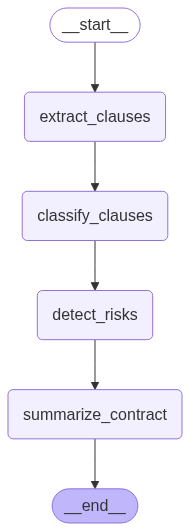

In [42]:
png = app.get_graph().draw_mermaid_png()
display(Image(png))

### Sample Output

In [43]:
contract_text = """
This agreement is between Party A and Party B for software licensing.
The license is granted for 2 years with a renewal option.
Payment shall be made quarterly.
The contract may be terminated with 30 days' notice.
The licensee shall indemnify the licensor against all claims.
"""

response = app.invoke({"contract": contract_text})

print("\n--- Summary ---")
print(response["summary"])

print("\n--- Risks ---")
for r in response["risks"]:
    print(f"- {r}")

print("\n--- Classified Clauses ---")
for c in response["classifications"]:
    print(f"[{c['label']}] {c['clause']}")


--- Summary ---
Here's a summary of the contract in simple language:

**What it's about:** This agreement is between two parties (A and B) for allowing Party A to use some software owned by Party B.

**How long:** The license will be valid for 2 years, with an option to renew after that.

**Payment:** Party A will pay Party B every quarter (every 3 months).

**Ending the agreement:** Either party can end the agreement by giving the other side 30 days' notice.

**Responsibility:** If someone makes a claim about the software being used in a way that's not allowed, Party A (the one using the software) will be responsible for fixing it and paying any costs.

--- Risks ---
- 'Introduction/Scope': **Moderate Risk**

The clause lacks essential details, leaving room for disputes about the scope of the agreement, the type of license being granted (e.g., perpetual, subscription-based), and the parties' rights and obligations. Clarifying these points could mitigate legal risks.
- "Term/Duration"